## Lets import the libraries

In [10]:
import datetime
import pandas_datareader.data as web
import math
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

## We get the dataset, fill the NA values and define our labels

In [3]:
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2017, 1, 11)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

dfreg = df.loc[:,['Adj Close','Volume']]
dfreg['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100.0
dfreg['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
last_date = dfreg.iloc[-1].name

## Now that we have the data cleaned we can get the Training Dataset

In [4]:
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]

C:\Users\80211447\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\sklearn\preprocessing\data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


## Load the libraries for our models and train them

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X_train, y_train)
confidencereg = clfreg.score(X_test, y_test)

# Quadratic Regression
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X_train, y_train)
confidencepoly2 = clfpoly2.score(X_test,y_test)

# Lasso Regression
clfpoly3 = Lasso(alpha=0.1)
clfpoly3.fit(X_train, y_train)
confidencepoly3 = clfpoly3.score(X_test,y_test)

print(confidencereg, confidencepoly2, confidencepoly3)

model_names = ["Linear", "Quadratic", "Lasso"]
models = {model_names[0]: clfreg, 
          model_names[1]: clfpoly2, 
          model_names[2]: clfpoly3}

0.9660835062608152 0.9637736198109836 0.966398166219373


## Define a function to forecast using a specific model from the 3 available

In [11]:
def custom_prediction(model_name):
    forecast_set = models[model_name].predict(X_lately)
    dfreg['Forecast'] = np.nan
    #last_date = dfreg.iloc[-1].name
    last_unix = last_date
    next_unix = last_unix + datetime.timedelta(days=1)
    
    for i in forecast_set:
        next_date = next_unix
        next_unix += datetime.timedelta(days=1)
        dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
    df_plot = dfreg[['Adj Close','Forecast']].tail(100)
    df_plot.rename(columns={'Forecast': model_name + ' Forecast'}, 
                     inplace=True)
    df_plot.plot()
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()
    return df_plot

## It is time to show the results for the three 

Graph for the model,  Linear


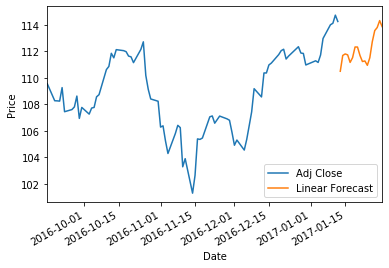

Graph for the model,  Quadratic


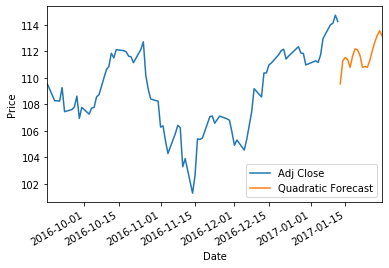

Graph for the model,  Lasso


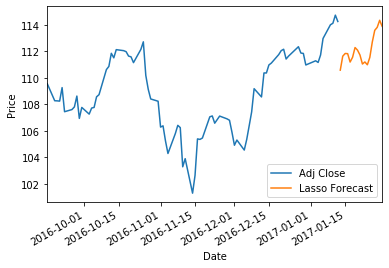

In [12]:
for m in model_names:
    print("Graph for the model, ", m)
    custom_prediction(m)